### Comparing Custom SHAP Approximator with Original SHAP on Simulated Data

In this notebook, we will:

- Simulate both tabular and sequential data with known true feature importances.
- Train models (XGBoost for tabular data and LSTM for sequential data) on the simulated data.
- Compute SHAP values using both the original SHAP package and a custom SHAP approximator.
- Compare the SHAP values from both methods with each other and with the true feature importances.
- Analyze and visualize the results.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr

from ESHAP import TabularDataSimulator, SequentialDataSimulator
from ESHAP import TabularSHAPApproximator, SequentialSHAPApproximator

#### Simulate Tabular Data


In [7]:
# Simulate tabular data
tabular_simulator = TabularDataSimulator(n_samples=1000, n_features=10)
X, y = tabular_simulator.get_data()
true_importances = tabular_simulator.get_true_importances()

# Convert to NumPy array if necessary
if isinstance(X, pd.DataFrame):
    X = X.values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# Train XGBoost model
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# Compute SHAP values using SHAP package
explainer_shap = shap.TreeExplainer(model_xgb)
shap_values_shap = explainer_shap.shap_values(X_test)

In [10]:
# Initialize custom SHAP approximator
custom_shap_approximator = TabularSHAPApproximator(model_xgb, X_train, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom = custom_shap_approximator.compute_shap_values(X_test)


In [11]:
# Compute mean absolute SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values_shap), axis=0)
mean_abs_custom_shap_values = np.mean(np.abs(shap_values_custom), axis=0)

# Normalize SHAP values
norm_mean_abs_shap_values = mean_abs_shap_values / np.sum(mean_abs_shap_values)
norm_mean_abs_custom_shap_values = mean_abs_custom_shap_values / np.sum(mean_abs_custom_shap_values)

# Create DataFrame for comparison
feature_names = [f'Feature {i}' for i in range(X.shape[1])]
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'True Importance': true_importances,
    'Original SHAP': norm_mean_abs_shap_values,
    'Custom SHAP': norm_mean_abs_custom_shap_values
})

print(comparison_df)

     Feature  True Importance  Original SHAP  Custom SHAP
0  Feature 0         0.066169       0.047916     0.049618
1  Feature 1         0.032279       0.016597     0.019970
2  Feature 2         0.145132       0.145824     0.145772
3  Feature 3         0.137727       0.132948     0.132782
4  Feature 4         0.099191       0.080152     0.080050
5  Feature 5         0.000923       0.006186     0.012083
6  Feature 6         0.201961       0.252754     0.244991
7  Feature 7         0.056470       0.033924     0.035572
8  Feature 8         0.085244       0.064482     0.064622
9  Feature 9         0.174906       0.219217     0.214539


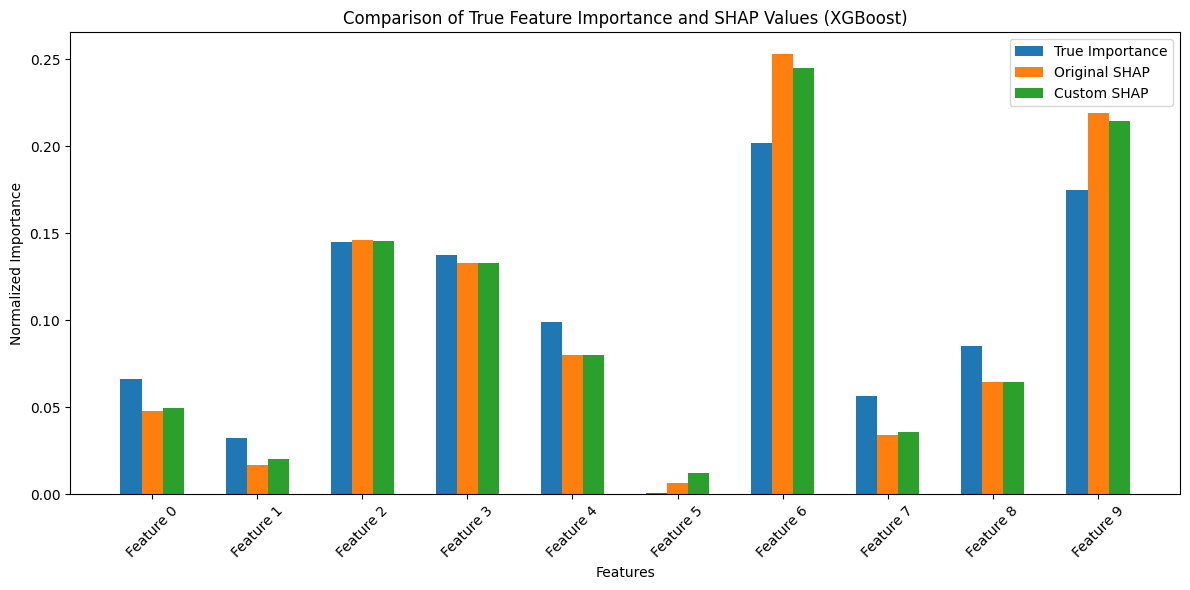

In [12]:
# Plot comparison
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(feature_names))

plt.bar(index, comparison_df['True Importance'], bar_width, label='True Importance')
plt.bar(index + bar_width, comparison_df['Original SHAP'], bar_width, label='Original SHAP')
plt.bar(index + 2*bar_width, comparison_df['Custom SHAP'], bar_width, label='Custom SHAP')

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Feature Importance and SHAP Values (XGBoost)')
plt.xticks(index + bar_width, feature_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Correlation with true importances
corr_true_original, _ = pearsonr(true_importances, norm_mean_abs_shap_values)
corr_true_custom, _ = pearsonr(true_importances, norm_mean_abs_custom_shap_values)

print(f'Correlation between True Importances and Original SHAP (XGBoost): {corr_true_original:.4f}')
print(f'Correlation between True Importances and Custom SHAP (XGBoost): {corr_true_custom:.4f}')

Correlation between True Importances and Original SHAP (XGBoost): 0.9742
Correlation between True Importances and Custom SHAP (XGBoost): 0.9730


#### Simulate Sequential Data

In [14]:
# Simulate sequential data
sequential_simulator = SequentialDataSimulator(n_samples=1000, timesteps=10, features=1)
X_seq, y_seq = sequential_simulator.get_data()
true_influences = sequential_simulator.get_true_importances()

# Ensure correct shape
if len(X_seq.shape) != 3:
    X_seq = X_seq.reshape((X_seq.shape[0], sequential_simulator.timesteps, sequential_simulator.features))

# Split data
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2)

In [15]:
# Define LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Set parameters
input_size = sequential_simulator.features
hidden_size = 50
output_size = 1

# Initialize model, loss function, and optimizer
model_lstm = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)

# Train LSTM model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model_lstm.train()
    permutation = torch.randperm(X_train_seq_tensor.size(0))
    for i in range(0, X_train_seq_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train_seq_tensor[indices], y_train_seq_tensor[indices]

        # Forward pass
        outputs = model_lstm(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 7.1867
Epoch [2/10], Loss: 8.0188
Epoch [3/10], Loss: 4.7108
Epoch [4/10], Loss: 10.0478
Epoch [5/10], Loss: 7.4624
Epoch [6/10], Loss: 6.0934
Epoch [7/10], Loss: 9.1423
Epoch [8/10], Loss: 9.6137
Epoch [9/10], Loss: 4.0230
Epoch [10/10], Loss: 6.6303


In [16]:
# Sample data for SHAP computations
X_train_sample_seq = X_train_seq[:100]
X_test_sample_seq = X_test_seq[:10]

# Compute SHAP values using DeepExplainer
model_lstm.eval()
X_train_sample_seq_tensor = torch.tensor(X_train_sample_seq, dtype=torch.float32)
explainer_shap_seq = shap.DeepExplainer(model_lstm, X_train_sample_seq_tensor)
shap_values_shap_seq = explainer_shap_seq.shap_values(torch.tensor(X_test_sample_seq, dtype=torch.float32), check_additivity=False)

/home/niyang/miniconda3/envs/shap/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LSTM
  warnings.warn(f"unrecognized nn.Module: {module_type}")


In [17]:
# Initialize custom SHAP approximator
custom_shap_approximator_seq = SequentialSHAPApproximator(model_lstm, X_train_sample_seq, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom_seq = custom_shap_approximator_seq.compute_shap_values(X_test_sample_seq)

# Compute SHAP values using custom approximator in batch mode
shap_values_custom_seq_batch = custom_shap_approximator_seq.batch_approximate_shap_values(X_test_sample_seq)

In [18]:
# Compute mean absolute SHAP values for the original SHAP values
mean_abs_shap_values_seq = np.mean(np.abs(shap_values_shap_seq), axis=0).flatten()
# Compute mean absolute SHAP values for the custom SHAP values (per sample and batch mode)
mean_abs_custom_shap_values_seq = np.mean(np.abs(shap_values_custom_seq), axis=0).flatten()
mean_abs_custom_shap_values_seq_batch = np.mean(np.abs(shap_values_custom_seq_batch), axis=0).flatten()

# Normalize SHAP values
norm_mean_abs_shap_values_seq = mean_abs_shap_values_seq / np.sum(mean_abs_shap_values_seq)
norm_mean_abs_custom_shap_values_seq = mean_abs_custom_shap_values_seq / np.sum(mean_abs_custom_shap_values_seq)
norm_mean_abs_custom_shap_values_seq_batch = mean_abs_custom_shap_values_seq_batch / np.sum(mean_abs_custom_shap_values_seq_batch)

# Create DataFrame for comparison
time_steps = np.arange(len(true_influences))
comparison_seq_df = pd.DataFrame({
    'Time Step': time_steps,
    'True Influence': true_influences,
    'Original SHAP': norm_mean_abs_shap_values_seq,
    'Custom SHAP (Per Sample)': norm_mean_abs_custom_shap_values_seq,
    'Custom SHAP (Batch)': norm_mean_abs_custom_shap_values_seq_batch
})

print(comparison_seq_df)

   Time Step  True Influence  Original SHAP  Custom SHAP (Per Sample)  \
0          0        0.006936       0.006282                  0.005770   
1          1        0.063664       0.018768                  0.012876   
2          2        0.065947       0.035792                  0.023781   
3          3        0.215350       0.068832                  0.039424   
4          4        0.179467       0.089850                  0.079270   
5          5        0.043728       0.020179                  0.036962   
6          6        0.093208       0.104897                  0.095072   
7          7        0.149625       0.338599                  0.369348   
8          8        0.084354       0.063055                  0.088091   
9          9        0.097722       0.253747                  0.249407   

   Custom SHAP (Batch)  
0             0.005089  
1             0.016466  
2             0.025731  
3             0.061039  
4             0.070109  
5             0.072429  
6             0.10981

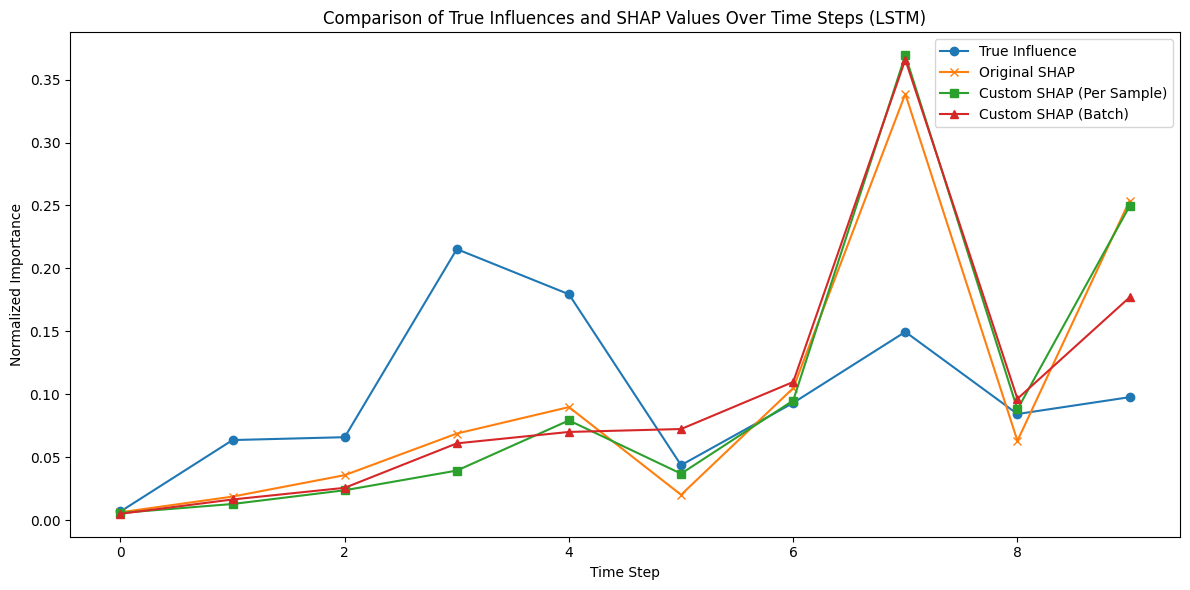

In [19]:
# Plot comparison over time steps
plt.figure(figsize=(12, 6))
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['True Influence'], marker='o', label='True Influence')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Original SHAP'], marker='x', label='Original SHAP')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Custom SHAP (Per Sample)'], marker='s', label='Custom SHAP (Per Sample)')
plt.plot(comparison_seq_df['Time Step'], comparison_seq_df['Custom SHAP (Batch)'], marker='^', label='Custom SHAP (Batch)')
plt.xlabel('Time Step')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Influences and SHAP Values Over Time Steps (LSTM)')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Correlation with true influences
corr_true_original_seq, _ = pearsonr(true_influences, norm_mean_abs_shap_values_seq)
corr_true_custom_seq, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_seq)
corr_true_custom_seq_batch, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_seq_batch)

print(f'Correlation between True Influences and Original SHAP (LSTM): {corr_true_original_seq:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Per Sample, LSTM): {corr_true_custom_seq:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Batch, LSTM): {corr_true_custom_seq_batch:.4f}')

Correlation between True Influences and Original SHAP (LSTM): 0.4111
Correlation between True Influences and Custom SHAP (Per Sample, LSTM): 0.3345
Correlation between True Influences and Custom SHAP (Batch, LSTM): 0.3621


#### Simulate Sequential Data and Train Transformer Model

In [21]:
# Define Transformer model in PyTorch
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead, num_layers):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        transformer_out = self.transformer(x)
        out = self.fc(transformer_out[:, -1, :])
        return out

# Set parameters
hidden_size = 50
nhead = 5
num_layers = 2

# Initialize model, loss function, and optimizer
model_transformer = TransformerModel(input_size, hidden_size, output_size, nhead, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)

# Train Transformer model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model_transformer.train()
    permutation = torch.randperm(X_train_seq_tensor.size(0))
    for i in range(0, X_train_seq_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train_seq_tensor[indices], y_train_seq_tensor[indices]

        # Forward pass
        outputs = model_transformer(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/home/niyang/miniconda3/envs/shap/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/10], Loss: 5.3289
Epoch [2/10], Loss: 6.0323
Epoch [3/10], Loss: 8.9999
Epoch [4/10], Loss: 6.0769
Epoch [5/10], Loss: 8.8808
Epoch [6/10], Loss: 6.8420
Epoch [7/10], Loss: 9.1208
Epoch [8/10], Loss: 5.9379
Epoch [9/10], Loss: 7.7010
Epoch [10/10], Loss: 6.2091


In [22]:
# Sample data for SHAP computations
X_train_sample_seq = X_train_seq[:100]
X_test_sample_seq = X_test_seq[:10]

# Compute SHAP values using DeepExplainer
model_transformer.eval()
X_train_sample_seq_tensor = torch.tensor(X_train_sample_seq, dtype=torch.float32)
explainer_shap_transformer = shap.DeepExplainer(model_transformer, X_train_sample_seq_tensor)
shap_values_shap_transformer = explainer_shap_transformer.shap_values(torch.tensor(X_test_sample_seq, dtype=torch.float32), check_additivity=False)

# Ensure correct output format
if isinstance(shap_values_shap_transformer, list):
    shap_values_shap_transformer = shap_values_shap_transformer[0]

/home/niyang/miniconda3/envs/shap/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")


In [23]:
# Initialize custom SHAP approximator
custom_shap_approximator_transformer = SequentialSHAPApproximator(model_transformer, X_train_sample_seq, num_samples=100)

# Compute SHAP values using custom approximator
shap_values_custom_transformer = custom_shap_approximator_transformer.compute_shap_values(X_test_sample_seq)

# Compute SHAP values using custom approximator in batch mode
shap_values_custom_transformer_batch = custom_shap_approximator_transformer.batch_approximate_shap_values(X_test_sample_seq)

In [24]:
# Compute mean absolute SHAP values for the original SHAP values
mean_abs_shap_values_transformer = np.mean(np.abs(shap_values_shap_transformer), axis=0).flatten()
# Compute mean absolute SHAP values for the custom SHAP values (per sample and batch mode)
mean_abs_custom_shap_values_transformer = np.mean(np.abs(shap_values_custom_transformer), axis=0).flatten()
mean_abs_custom_shap_values_transformer_batch = np.mean(np.abs(shap_values_custom_transformer_batch), axis=0).flatten()

# Normalize SHAP values
norm_mean_abs_shap_values_transformer = mean_abs_shap_values_transformer / np.sum(mean_abs_shap_values_transformer)
norm_mean_abs_custom_shap_values_transformer = mean_abs_custom_shap_values_transformer / np.sum(mean_abs_custom_shap_values_transformer)
norm_mean_abs_custom_shap_values_transformer_batch = mean_abs_custom_shap_values_transformer_batch / np.sum(mean_abs_custom_shap_values_transformer_batch)

# Create DataFrame for comparison
time_steps = np.arange(len(true_influences))
comparison_transformer_df = pd.DataFrame({
    'Time Step': time_steps,
    'True Influence': true_influences,
    'Original SHAP': norm_mean_abs_shap_values_transformer,
    'Custom SHAP (Per Sample)': norm_mean_abs_custom_shap_values_transformer,
    'Custom SHAP (Batch)': norm_mean_abs_custom_shap_values_transformer_batch
})

print(comparison_transformer_df)

   Time Step  True Influence  Original SHAP  Custom SHAP (Per Sample)  \
0          0        0.006936       0.010577                  0.009764   
1          1        0.063664       0.045209                  0.028121   
2          2        0.065947       0.051344                  0.020041   
3          3        0.215350       0.028326                  0.030019   
4          4        0.179467       0.028843                  0.033791   
5          5        0.043728       0.033034                  0.011988   
6          6        0.093208       0.035239                  0.015570   
7          7        0.149625       0.030974                  0.027015   
8          8        0.084354       0.034057                  0.022545   
9          9        0.097722       0.702398                  0.801145   

   Custom SHAP (Batch)  
0             0.008323  
1             0.016854  
2             0.031149  
3             0.010587  
4             0.011359  
5             0.012010  
6             0.00802

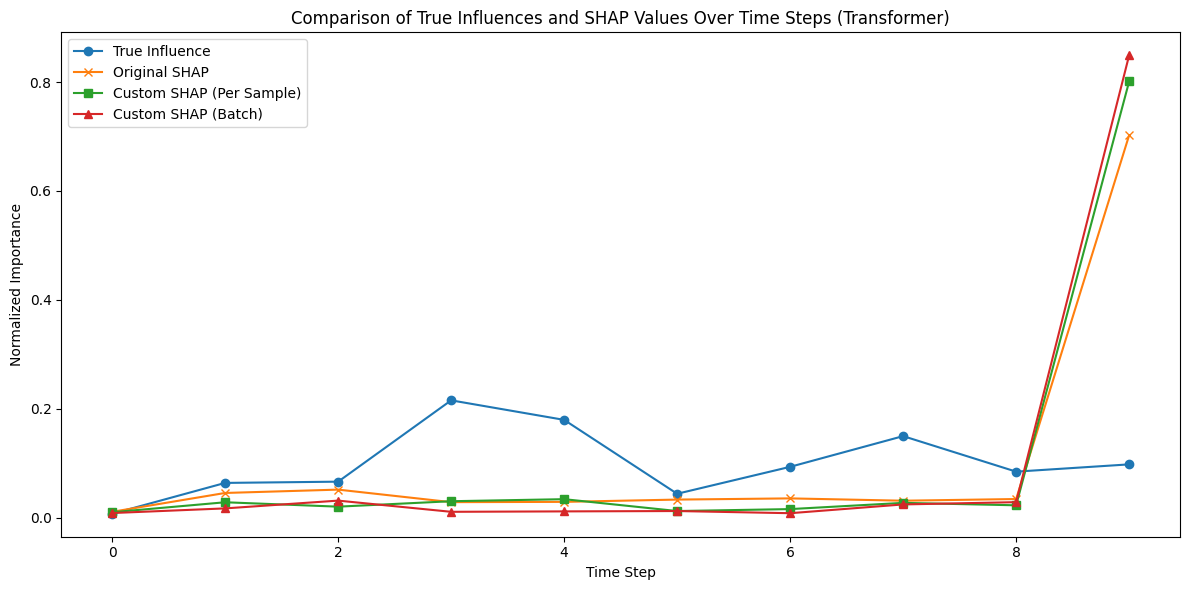

In [25]:
# Plot comparison over time steps
plt.figure(figsize=(12, 6))
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['True Influence'], marker='o', label='True Influence')
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['Original SHAP'], marker='x', label='Original SHAP')
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['Custom SHAP (Per Sample)'], marker='s', label='Custom SHAP (Per Sample)')
plt.plot(comparison_transformer_df['Time Step'], comparison_transformer_df['Custom SHAP (Batch)'], marker='^', label='Custom SHAP (Batch)')
plt.xlabel('Time Step')
plt.ylabel('Normalized Importance')
plt.title('Comparison of True Influences and SHAP Values Over Time Steps (Transformer)')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Correlation with true influences
corr_true_original_transformer, _ = pearsonr(true_influences, norm_mean_abs_shap_values_transformer)
corr_true_custom_transformer, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_transformer)
corr_true_custom_transformer_batch, _ = pearsonr(true_influences, norm_mean_abs_custom_shap_values_transformer_batch)

print(f'Correlation between True Influences and Original SHAP (Transformer): {corr_true_original_transformer:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Per Sample, Transformer): {corr_true_custom_transformer:.4f}')
print(f'Correlation between True Influences and Custom SHAP (Batch, Transformer): {corr_true_custom_transformer_batch:.4f}')

Correlation between True Influences and Original SHAP (Transformer): -0.0124
Correlation between True Influences and Custom SHAP (Per Sample, Transformer): 0.0135
Correlation between True Influences and Custom SHAP (Batch, Transformer): -0.0148
